# A practical intro to Principal Component Analysis in Python
F. Balogh

2023/08/11

Principal component analysis (PCA) is a common first step to explore large datasets, to extract individual or mixed features that contribute the most to the variability of the data, and to perform dimensionality reduction to make further analysis computationally less expensive.

Suppose that we have $n$ samples with $p$ features observed for each sample point. In "omics" datasets it is common that the number of features is much larger than the number of samples. For simplicity, we assume that there is no missing data - if there is, we need to take extra measures before we can start the analysis of data.

Geometrically, we can imagine the $n$ samples as a cloud of points in $p$-dimensional space: the feature values of an individual sample can be thought of as the coordinates that describe the location of the sample point in $p$-space.

To illustrate the ideas that will follow, let us visualize a simple two-dimensional synthetic dataset using common Python modules. First the necessary modules will have to be imported; see the comments after the # sign for a short description for what each module does.

In [1]:
import pandas                   # module to load and manipulate data tables
import matplotlib.pyplot as plt # module to create versatile graphs
import seaborn                  # module to create stat-specific plots of data

## A two-dimensional dataset - loading and visualizing data

We are now ready to read in our dataset from the external csv file *data.csv* by using the module Pandas.

In [2]:
Cloud=pandas.read_csv('data.csv') #import raw data from external file

No news is good news: if there is no error message, this means that the dataset is now loaded and ready for exploration.

The data is loaded into a **dataframe**, a tabular dataset with rows (samples) and columns (features).

 We can verify that all is good by printing out the dataset.

In [3]:
print(Cloud)

         F1      F2
0     2.526  -0.451
1     6.998   4.374
2     5.840   2.217
3    10.336   7.869
4     8.591   6.462
..      ...     ...
195   6.322   0.664
196  19.032  17.013
197   9.778   4.694
198  13.913  12.191
199  11.581  12.176

[200 rows x 2 columns]


Note that only a small portion of the dataset is printed, enough so that we can verify the structure and the labelling of the data.

In each module there are standard procedures to manipulate the related data structures and to find various properties of them. For example, we can read out the number of rows and columns from a dataframe in the following way:

In [4]:
n = Cloud.shape[0]
print(n)
p = Cloud.shape[1]
print(p)

200
2


To get a visual representation, we can use the scatterplot command from the seaborn package:

<AxesSubplot:xlabel='F1', ylabel='F2'>

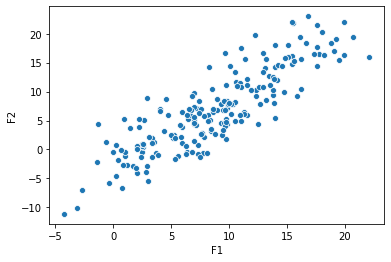

In [5]:
seaborn.scatterplot(data=Cloud, x="F1", y="F2")

Using a bit more sophisticated code, we can set the viewing window of the scatterplot:

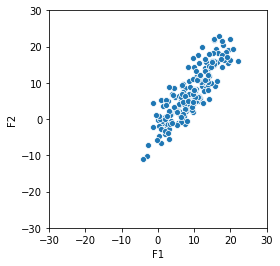

In [6]:
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-30, 30) # setting the range along the x-axis
ax.set_ylim(-30, 30) # setting the range along the y-axis
plt.show()

We can see in the plot above that the "center of mass" of the data off the origin (0,0). We can find the location of the geometric center of the sample by calculating the mean (average) of the features along the columns. This can be done as follows:

In [7]:
m=Cloud.mean(axis=0)
print(m)

F1    8.73337
F2    6.87638
dtype: float64


The following figure now shows the geometric location of the mean (red star).

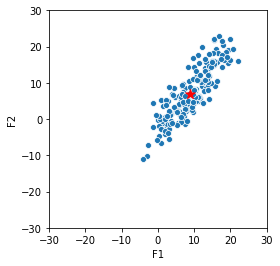

In [8]:
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-30, 30) # setting the range along the x-axis
ax.set_ylim(-30, 30) # setting the range along the y-axis
plt.scatter([m[0]],[m[1]],color="red", marker="*",s=100) # the center of mass plotted in red
plt.show()

We can center the dataset by subtracting the mean of the corresponding column from each entry in the data frame:

In [9]:
Cloud_centered = Cloud - Cloud.mean(axis=0)

           F1        F2
0    -6.20737  -7.32738
1    -1.73537  -2.50238
2    -2.89337  -4.65938
3     1.60263   0.99262
4    -0.14237  -0.41438
..        ...       ...
195  -2.41137  -6.21238
196  10.29863  10.13662
197   1.04463  -2.18238
198   5.17963   5.31462
199   2.84763   5.29962

[200 rows x 2 columns]


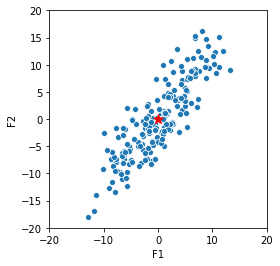

In [10]:
print(Cloud_centered)
fig, ax = plt.subplots()
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

We see that the source of variability cannot be identified with a single feature; the spread of the data points is maximized along a direction that is not aligned with either of the coordinate axes. This leads to the following idea: **search for a direction (i.e a linear combination of the features) along which the variance of the dataset is maximized**.

To do this, we set up the necessary mathematical formalism first. The data will be presented as an $n \times p$ Matrix $X$:
$$
X = \begin{bmatrix}
 x_{11} & x_{12} & \cdots & x_{1p} \cr
 x_{21} & x_{22} & \cdots & x_{2p} \cr
 \vdots & \vdots & \ddots & \vdots \cr
 x_{n1} & x_{n2} & \cdots & x_{np} 
\end{bmatrix}
$$
The rows correspond to samples, the columns are associated with the features observed.

From now on, we will assume that $X$ is centered (the column means are all equal to zero).

Note that in our pedagogical example $n$ is much larger than $p$. However, in many applications of principal component analysis it is common to have much more features than samples ($p >>n$).

To implement this matrix-based approach and use numerical arrays to represent our data, we import the module **numpy**:

In [11]:
import numpy as np

np.set_printoptions(precision=4,suppress=True) #set the number of decimals shown when printing

Now the centralized data frame can be converted to a matrix:

In [12]:
X=Cloud_centered.to_numpy()
print(X)

[[ -6.2074  -7.3274]
 [ -1.7354  -2.5024]
 [ -2.8934  -4.6594]
 [  1.6026   0.9926]
 [ -0.1424  -0.4144]
 [  7.4166  12.4716]
 [ -8.5174 -11.5154]
 [  3.4976  12.9336]
 [ -1.9704   2.3596]
 [  4.3566   7.1396]
 [  1.8006   1.4086]
 [-10.1314  -9.1034]
 [ -1.3174   0.0746]
 [ -4.2014   1.7946]
 [  2.2756  -1.9254]
 [  0.5756  -2.2854]
 [  1.4406   0.9726]
 [ -0.5524  -0.9074]
 [  1.0186  -1.5384]
 [  0.8046  -2.2434]
 [  0.5846   1.0026]
 [ -3.6054  -4.8624]
 [ -2.7834  -3.0394]
 [  4.7596   5.8886]
 [  3.5566   2.3576]
 [  2.3396  10.7266]
 [  1.0986   1.4346]
 [ -1.5984   0.2106]
 [  1.0206  -5.0184]
 [ -6.3714  -8.1474]
 [ -7.6884  -7.9694]
 [ -7.7324  -7.3464]
 [  2.5576  -0.4804]
 [ -3.5144  -4.3744]
 [  7.0946   2.3096]
 [  1.1216  -2.4264]
 [ -0.9414  -7.5624]
 [  7.4986   8.7966]
 [ -6.1794  -6.5214]
 [ -6.2074  -6.3154]
 [ -7.0414  -9.6864]
 [  7.8966  11.4836]
 [  6.7076   9.2086]
 [ -5.0094  -7.4794]
 [ -1.7924   2.8356]
 [ 10.7276   8.4996]
 [ -5.7914  -9.7004]
 [ -0.2984  -

In two dimensions, a direction can be parametrized by a vector
$$
\vec{u} = \begin{bmatrix}
u_1 \cr
u_2
\end{bmatrix}.
$$
We assume that the two entries of $\vec{u}$ are not zero simultaneously, that is, the length of $\vec{u}$ different from zero. 

Since a constant multiple of a vector gives the same direction, we can restrict ourselves to vectors of unit length; in terms of the entries of $\vec{u}$ this means
$$
u_1^2+u_2^2 =1.
$$
A data point - a vector $\vec{x}$, a row vector of the matrix $X$  - can be projected to the line spanned by the unit direction vector $\vec{u}$ by taking the product
$$\vec{x}\cdot\vec{u}$$
of $\vec{v}$ with $\vec{u}$ and measure it along the direction of $\vec{u}$.

For example,

In [13]:
alpha=2*np.pi/3
u=np.array( [[np.cos(alpha)],[np.sin(alpha)]] )
print(u)

[[-0.5  ]
 [ 0.866]]


In [14]:
X_projected=np.matmul(X,u)
print(X_projected)

[[-3.242 ]
 [-1.2994]
 [-2.5885]
 [ 0.0583]
 [-0.2877]
 [ 7.0924]
 [-5.7139]
 [ 9.452 ]
 [ 3.0287]
 [ 4.0048]
 [ 0.3196]
 [-2.8181]
 [ 0.7233]
 [ 3.6549]
 [-2.8052]
 [-2.267 ]
 [ 0.122 ]
 [-0.5096]
 [-1.8416]
 [-2.3451]
 [ 0.576 ]
 [-2.4083]
 [-1.2405]
 [ 2.7199]
 [ 0.2634]
 [ 8.1197]
 [ 0.6931]
 [ 0.9816]
 [-4.8564]
 [-3.8702]
 [-3.0575]
 [-2.496 ]
 [-1.6948]
 [-2.0311]
 [-1.5471]
 [-2.6621]
 [-6.0785]
 [ 3.8688]
 [-2.558 ]
 [-2.3656]
 [-4.868 ]
 [ 5.9968]
 [ 4.6211]
 [-3.9726]
 [ 3.3519]
 [ 1.9971]
 [-5.5051]
 [-3.0269]
 [-0.422 ]
 [-0.5548]
 [-0.4796]
 [-0.2658]
 [ 2.3334]
 [ 0.6933]
 [-2.2222]
 [-0.2137]
 [ 0.8518]
 [ 9.5811]
 [-0.6953]
 [-2.5263]
 [ 3.5298]
 [-5.3394]
 [ 7.0349]
 [ 1.9953]
 [-0.7819]
 [-3.6537]
 [ 0.8335]
 [-0.8874]
 [-0.1506]
 [ 9.8268]
 [ 7.5347]
 [ 5.7933]
 [ 2.3777]
 [-6.0231]
 [-6.4769]
 [-5.1906]
 [ 2.3984]
 [-2.7136]
 [-0.3983]
 [-1.9378]
 [-2.0331]
 [-3.3594]
 [-2.016 ]
 [ 3.8723]
 [-6.1534]
 [ 2.63  ]
 [-4.5324]
 [ 6.1929]
 [-1.5604]
 [ 2.475 ]
 [ 3.6918]

In [15]:
X_proj_embedded=np.matmul(X_projected,np.transpose(u))
print(X_proj_embedded)

[[ 1.621  -2.8077]
 [ 0.6497 -1.1253]
 [ 1.2942 -2.2417]
 [-0.0292  0.0505]
 [ 0.1438 -0.2491]
 [-3.5462  6.1422]
 [ 2.857  -4.9484]
 [-4.726   8.1857]
 [-1.5143  2.6229]
 [-2.0024  3.4682]
 [-0.1598  0.2768]
 [ 1.409  -2.4405]
 [-0.3617  0.6264]
 [-1.8274  3.1652]
 [ 1.4026 -2.4294]
 [ 1.1335 -1.9633]
 [-0.061   0.1057]
 [ 0.2548 -0.4414]
 [ 0.9208 -1.5949]
 [ 1.1726 -2.031 ]
 [-0.288   0.4988]
 [ 1.2041 -2.0856]
 [ 0.6202 -1.0743]
 [-1.3599  2.3555]
 [-0.1317  0.2281]
 [-4.0599  7.0319]
 [-0.3466  0.6002]
 [-0.4908  0.8501]
 [ 2.4282 -4.2057]
 [ 1.9351 -3.3517]
 [ 1.5288 -2.6479]
 [ 1.248  -2.1616]
 [ 0.8474 -1.4678]
 [ 1.0156 -1.759 ]
 [ 0.7736 -1.3398]
 [ 1.3311 -2.3055]
 [ 3.0393 -5.2642]
 [-1.9344  3.3505]
 [ 1.279  -2.2153]
 [ 1.1828 -2.0487]
 [ 2.434  -4.2158]
 [-2.9984  5.1934]
 [-2.3105  4.002 ]
 [ 1.9863 -3.4404]
 [-1.676   2.9028]
 [-0.9985  1.7295]
 [ 2.7525 -4.7675]
 [ 1.5134 -2.6213]
 [ 0.211  -0.3655]
 [ 0.2774 -0.4805]
 [ 0.2398 -0.4153]
 [ 0.1329 -0.2302]
 [-1.1667  2

The picture:

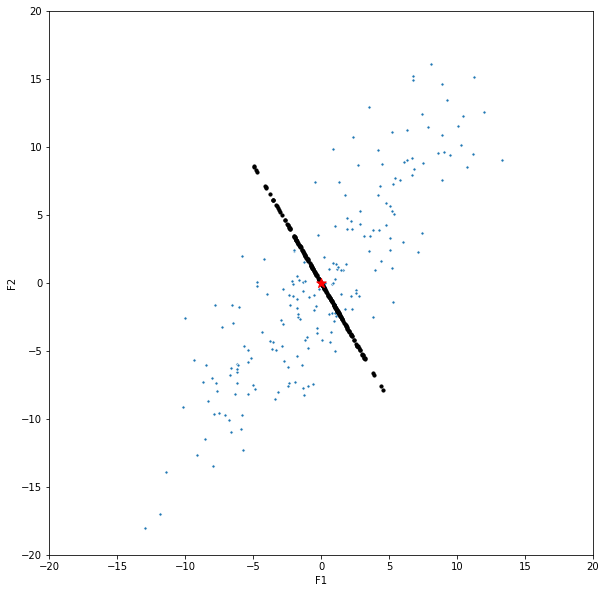

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Changing the direction of $\vec{u}$ gives different values of the spread of the data points:

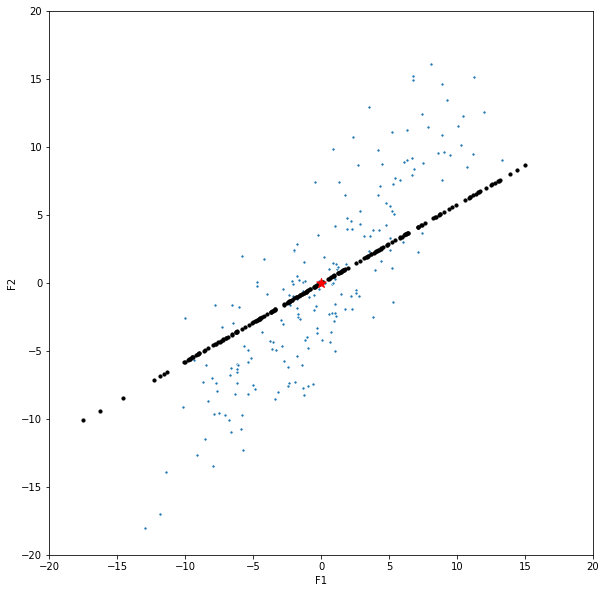

In [17]:
alpha=np.pi/6
u=np.array([[np.cos(alpha)],[np.sin(alpha)]])
X_projected=np.matmul(X,u)
X_proj_embedded=np.matmul(X_projected,np.transpose(u))

fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Here is the projection along the direction of the $x$ axis (feature F1):

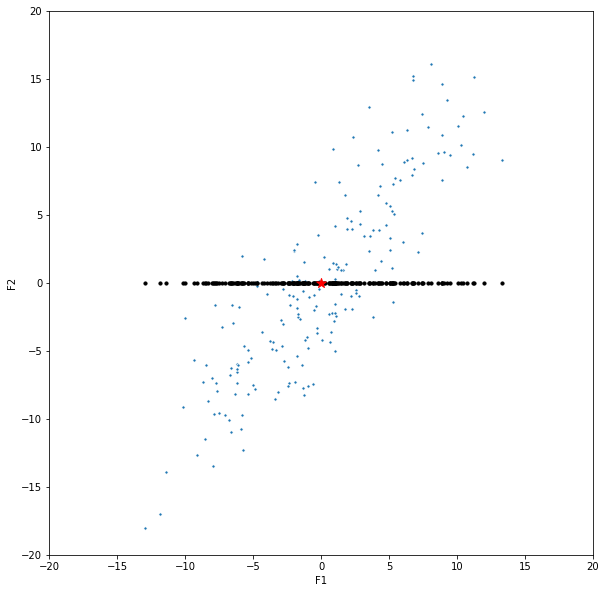

In [18]:
alpha=0
u=np.array([[np.cos(alpha)],[np.sin(alpha)]])
X_projected=np.matmul(X,u)
X_proj_embedded=np.matmul(X_projected,np.transpose(u))

fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
plt.scatter(X_proj_embedded[:,0],X_proj_embedded[:,1],color="black",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.scatter([0],[0],color="red", marker="*",s=100)
plt.show()

Now, how do we find the direction (line) $\vec{u}$ along which the variability of the data is maximized?

We need to maximize the variance of the numerical sample $X\vec{u}$ in $\vec{u}$ under the constraint that $\vec{u}$ is of unit length. Check the following by matrix multiplication:
1. The condition $\vec{u}$ is of length $1$ is the same as $\vec{u}^{T}\vec{u}=1$.
2. Given the assumption that $X$ is centered, the (sample) variance of $X\vec{u}$ is equal to
$$
Var(X\vec{u}) = \frac{1}{n-1}\vec{u}^{T}X^{T}X\vec{u}.
$$

In terms of the (sample) covariance matrix
$$
\mathbf{S} = \frac{1}{n-1}X^{T}X,
$$
we can rewrite the variance as
$$
Var(X\vec{u}) = \vec{u}^{T}\mathbf{S}\vec{u}.
$$

To confirm that $\mathbf S$ is consistent with the built-in covariance matrix of $X$, we run the following check:

In [19]:
1/(n-1)*np.matmul(np.transpose(X),X)

array([[28.9791, 31.7761],
       [31.7761, 47.2248]])

In [20]:
Cloud.cov()

,F1,F2
F1,28.979100,31.776113
F2,31.776113,47.224758


Therefore we arrive at the following constrained optimization problem:
$$
\left\{
\begin{array}{l}
\vec{u}^{T}\mathbf{S}\vec{u} \to \text{Max},\\
\vec{u}^{T}\vec{u}=1.
\end{array}\right.
$$
This constrained optimization problem can be solved by the method of Lagrange multipliers of multivariate calculus (Calculus III). 

It turns out that the vectors that maximize the projected variance have to be satisfy an equation of the following form:
$$
\mathbf{S}\vec{u} = \lambda \vec{u},
$$
where $\lambda$ is a number. This means that $\vec{u}$ spans a direction along which multiplication by the matrix $\mathbf{S}$ reduces to a multiplication by a number. In other words, the line spanned by the vector $\vec{u}$ is invariant under the linear transformation associated with $\mathbf{S}$. Such vectors are called the **eigenvectors** of the matrix $\mathbf{S}$, and the associated value $\lambda$ is called the corresponding **eigenvalue** (see [this Wikipedia article](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) for details).

For example, the matrix
$$
A = \begin{bmatrix} 
1 & 6 \cr
7 & 2
\cr\end{bmatrix}
$$
has two eigenvalues, $\lambda=-5$ and $\lambda=8$:
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix}
1 \cr
-1
\end{bmatrix}
=
\begin{bmatrix}
-5 \cr
5
\end{bmatrix}
=
-5\cdot\begin{bmatrix}
1 \cr 
-1
\end{bmatrix}
\text{ and }
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix}
6 \cr
7
\end{bmatrix}
=
\begin{bmatrix}
48 \cr
56
\end{bmatrix}
=
8\cdot\begin{bmatrix}
6 \cr 
7
\end{bmatrix}.
$$

The package numpy has a convenient linear algebra procedure **linalg.eig** for calculating the eigenvalues and the eigenvectors of a matrix:

In [21]:
A=np.array([[1,6],[7,2]])
np.linalg.eig(A)

(array([-5.,  8.]),
 array([[-0.7071, -0.6508],
        [ 0.7071, -0.7593]]))

Note that the procedure returns the array of eigenvalues and a matrix whose columns are the eigenvectors (these eigenvectors are listed in the same order as the eigenvalues).

Note also that the eigenvectors are determined only up to a constant since only the eigendirections matter; the Python procedure will return normalized eigenvalues (i.e. eigenvalues of length $1$). However, there is no canonical choice of sign either: if $\vec{u}$ is a normalized eigenvector then $=\vec{u}$ is also a normalized eigenvector, and they are both equally good as representatives of an invariant line of a linear transformation.

Some basic facts about eigenvalues and eigenvectors:
1. The eigenvalues of any matrix are the solutions of the polynomial equation
$$\det(A-\lambda I)=0,$$
where $\det$ is the determinant and $I$ stands for the identity matrix of matching the size of $A$.
2. A $k\times k$ matrix has exactly $k$ eigenvalues, but some of these values may be complex. For example, the matrix
$$
\begin{bmatrix} 
0 & 1 \cr
-1 & 0
\cr\end{bmatrix}
$$
has two complex eigenvalues $i$ and $-i$.
3. Eigenvectors corresponding to different eigenvalues are linearly independent. However, in case of multiple eigenvalues there may not be enough linearly independent eigenvectors to span a basis. For example the matrix
$$
\begin{bmatrix} 
3 & 1 \cr
0 & 3
\cr\end{bmatrix}
$$
has the eigenvalue $3$ with multiplicity $2$, but the corresponding eigenspace is one-dimesional: the only invariant line is spanned by the eigenvector 
$$
\begin{bmatrix} 
1 \cr
0 
\end{bmatrix}.
$$
4. If a $k\times k$ matrix $A$ has $k$ independent eigenvectors, then $A$ is **diagonalizable**, that is, in the eigenvector basis $A$ acts diagonally. More precisely, if $\lambda_1, \ldots, \lambda_k$ are the eigenvalues and $U$ is the matrix composed from the column eigenvectors following the same labelling, we have
$$
A U = U\mathop{diag}(\lambda_1, \ldots, \lambda_k),
$$
or
$$
A = U\mathop{diag}(\lambda_1, \ldots, \lambda_k)U^{-1}.
$$
For example, check that
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
=
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
\begin{bmatrix} 
-5 & 0 \cr
0 & 8\cr
\end{bmatrix}
$$
or
$$
\begin{bmatrix} 
1 & 6 \cr
7 & 2\cr
\end{bmatrix}
=
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}
\begin{bmatrix} 
-5 & 0 \cr
0 & 8\cr
\end{bmatrix}
\begin{bmatrix} 
1 & 6 \cr
-1 & 7\cr
\end{bmatrix}^{-1}.
$$

Note that we are interested in the particular case of covariance matrices. These have the following special properties:
1. They are symmetric (a covariance matrix is equal to its transpose).
2. They are positive semidefinite (products of the form $\vec{u}\mathbf{S}\vec{u}$ are non-negative for all vectors $\vec{u}$.

The second property follows from the observation that $\vec{u}\mathbf{S}\vec{u}$ is the variance of a sample that is obtained from $X$ by taking linear combinations with coefficients given by the components of $\vec{u}$.

Luckily, a mathematical theorem guarantees the following for any matrix that satisfies the above properties:
1. All eigenvalues of $\mathbf{S}$ are non-negative real numbers.
2. The eigenvectors of $\mathbf{S}$ corresponding to different eigenvalues are orthogonal (not a given in the general case, only linear independence).
3. One can construct an orthonormal basis consisting of eigenvectors of $\mathbf{S}$.

This means that $\mathbf{S}= U \mathbf{D}U^{-1}$, where $\mathbf{D}$ is a diagonal matrix, and the columns of $U$ are orthogonal vectors. In particular, 
$$
U U^{T}=I \text{ and } U^{T}U=I
$$
and therefore $U^{-1}=U^{T}$.

This means that the variance function $\vec{u}^{T}u\mathbf{S}\vec{u}$ can be written as
$$
u^{T}\mathbf{S}\vec{u}=u^{T}U\mathbf{D}U^{T}\vec{u}.
$$

The key point to understand here is the geometric interpretation: if we change from the standard basis of the feature space to the orthonormal eigenbasis of $\mathbf{S}$, the covariance matrix becomes **diagonal**, i.e., the new basis vectors in the feature space are **uncorrelated**.

In our example below, we have the following matrices:

In [22]:
S=1/(n-1)*np.matmul(np.transpose(X),X)
print(S)

[[28.9791 31.7761]
 [31.7761 47.2248]]


The eigenvalues and the eigenvectors can now be calculated by the linalg.eig routine:

In [23]:
eigenvalues, U = np.linalg.eig(S)
D=np.zeros((p, p))
np.fill_diagonal(D,eigenvalues)
print(eigenvalues)
print(D)
print(U)

[ 5.0422 71.1617]
[[ 5.0422  0.    ]
 [ 0.     71.1617]]
[[-0.7987 -0.6017]
 [ 0.6017 -0.7987]]


The order of the eigenvalues is not guaranteed by linalg.eig. To make sure that they are in descending order (the order of importance for our purposes now), we can do the following: 
- we can find the list indices of the array that would make the list of eigenvalues descending (we can use np.argsort for this)
- we use the list to construct the $p\times p$ permutation matrix that will order the list of eigenvalues and the columns of the matrix of eigenvectors by multiplication *from the right* (action on columns).

In [24]:
final_index = np.argsort(-eigenvalues) # the negative sign is to ensure descending order
initial_index = np.arange(p)
permutation_matrix = np.zeros((p, p), dtype=int)
permutation_matrix[final_index, initial_index] = 1

eigenvalues=np.matmul(eigenvalues,permutation_matrix)
U=np.matmul(U,permutation_matrix)
D=np.matmul(np.transpose(permutation_matrix),np.matmul(D,permutation_matrix))
print("The eigenvalues are\n",eigenvalues)
print("U is\n", U)
print("D is\n ",D)

The eigenvalues are
 [71.1617  5.0422]
U is
 [[-0.6017 -0.7987]
 [-0.7987  0.6017]]
D is
  [[71.1617  0.    ]
 [ 0.      5.0422]]


Note that that permuting the eigenvalues and the eigenvectors by the same permutation does not change the identity $S=UDU^{T}$:
$$
UP (P^{T}DP) P^{T}U^{T} = UDU^{T}=S.
$$

Now that the eigenvalues and eigenvectors are properly ordered, let's plot the eigendirections of $\mathbf{S}$. These will be parametric plots of straight lines, the parameter value $t$ will be taken from the following array:

In [25]:
t=np.linspace(-200,200,100)

These values will be used in two plt.plot routines, using the entries of the respective column of the matrix $U$:

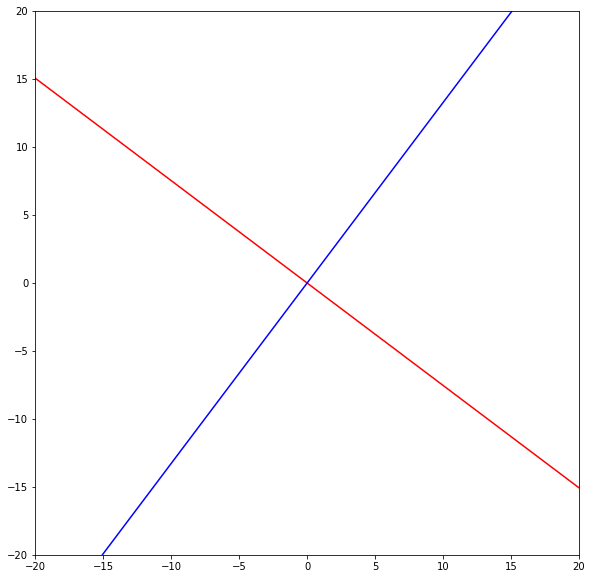

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.plot(t*U[0,0],t*U[1,0],color='blue')
plt.show()

Now we plot the data points together with the newly found orthogonal lines:

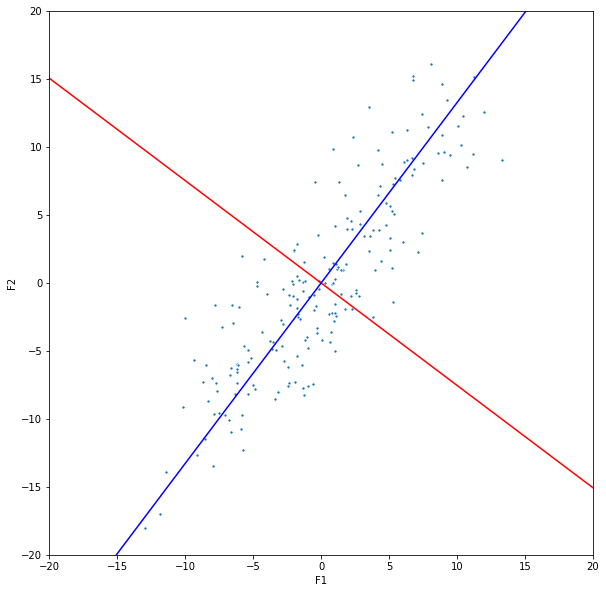

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.scatterplot(data=Cloud_centered, x="F1", y="F2",s=10)
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.plot(t*U[0,0],t*U[1,0],color='blue')
plt.show()

The geometric representation confirms what the algebra suggests: the direction along which the projected sample has the maximal variance is spanned by the eigenvector of the covariance matrix corresponding to the **largest eigenvalue**. We see also that the direction along which the variance of the projected sample is the smallest corresponds to the smallest eigenvalue.

In general, if we have $p$ features, all eigenvalues of the covariance matrix are distinct, and they are labelled in descending order
$$
\lambda_1 > \lambda_2 > \cdots > \lambda_p,
$$
we can rotate the coordinate system in the feature space in a unique way (up to sign), so that the $i$th coordinate is associated with a normalized eigenvector of $\lambda_i$. The directions of the new coordinate axes are called **principal directions**, and the corresponding coordinates are called **principal components**, labelled by the eigenvalue labels.

So in our graph above the red and the blue lines mark the first and the second principal directions, respectively.
The first principal component of any data point would determined from the dot product of the original feature vector with the eigenvector corresponding to the first (largest) eigenvalue. In our case, as
$$
u_1=\begin{bmatrix} 
1 \cr
0 
\end{bmatrix}.
$$
we have
$$
PC1 = (-0.60168526)\cdot F1 + (-0.79873327)\cdot F2,
$$
and
$$
PC2 = (-0.79873327)\cdot F1 + (0.60168526)\cdot F2.
$$

In general, the $i$th principal component is determined from the dot product of the original feature vector with the eigenvector corresponding to the $i$th eigenvalue $\lambda_i$.

The column vector $u_i$ of the matrix $U$ corresponding to the eigenvalue $\lambda_i$ is of length $1$ for all $i$. It is common practice to consider the projection of the original feature directions to the scaled vectors
$$
\frac{1}{\sqrt{\lambda_1}}\vec{u}_1, \dots, \frac{1}{\sqrt{\lambda_p}}\vec{u}_p.
$$

Note that, as our two-dimensional example shows below, the first principal direction does not coincide with the estimated regression line in general, with F1 as the independent variable and F2 as the dependent one. In fact, the principal components do not assume any ordering or hierarchy between variables, it is a "democratic" process in this sense. Principal directions and regression lines are both solutions of least square-type minimization problems, but they minimize for different geometric features, and hence their solutions are generally different.

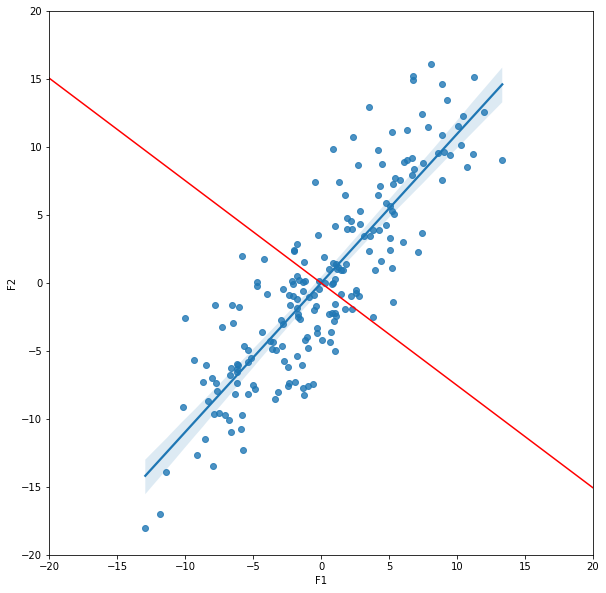

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
seaborn.regplot(data=Cloud_centered, x="F1", y="F2")
ax.set_aspect(1)
ax.set_xlim(-20, 20) 
ax.set_ylim(-20, 20) 
plt.plot(t*U[0,1],t*U[1,1],color='red')
plt.show()

The total variance of the sample is the sum of the variances of the features. These individual variances are the diagonal elements of the original covariance matrix. If we change to principal components,
$$
\mathbf{S} = U \mathbf{D}U^{-1}
$$
we cannot expect the diagonal elements to be equal one-by-one, but one can prove by linear algebra that the sum of the diagonal elements are the same. In other words, the total variance is preserved, but it will be re-distributed into $p$ packets of descending order. Since the variances of the principal components are exactly the diagonal elements of the matrix $D$, we get an interesting interpretation of the eigenvalues $\lambda_i$: the ratio
$$
\frac{\lambda_i}{\lambda_1+\ldots+\lambda_p}
$$
gives the proportion of the total variance that $i$th principal carries/responsible for. Also, if we pick any subset $i_1,i_2,\dots,i_k$ of the principal components, these explain
$$
\frac{\lambda_{i_1}+\ldots+\lambda_{i_k}}{\lambda_1+\ldots+\lambda_p}
$$
of the total variance.

In our example, these values are

In [29]:
eigenvalues/sum(eigenvalues)

array([0.9338, 0.0662])

Here is how we can do the same with the module *scikit.learn* which has a full implementation of PCA:

In [30]:
X_original=Cloud.to_numpy() #raw data converted to a numpy array

from sklearn.decomposition import PCA #loading the module
pca = PCA() #setting up the principal component analysis routine
pca.fit(X_original) #performing PCA on X_original

print("Explained variance ratios:\n",pca.explained_variance_ratio_)

Explained variance ratios:
 [0.9338 0.0662]


## A higher dimensional dataset

Now we will execute the same steps as before, first by using our own code step-by-step, and then by using the built-in routines of the scikit-learn module.

In [31]:
Our_Data=pandas.read_csv('data_5d.csv')
print(Our_Data)

         F1      F2      F3      F4      F5
0    63.277  45.348  11.617 -40.670  26.030
1    68.072  49.718  11.462 -40.971  31.331
2    63.468  47.830  12.579 -35.925  33.478
3    57.385  41.069  10.472 -36.978  23.439
4    57.085  42.841  12.517 -33.445  29.195
..      ...     ...     ...     ...     ...
795  65.615  48.390  10.917 -38.656  31.367
796  62.873  47.029  10.045 -35.273  32.310
797  62.478  45.925  11.333 -37.734  29.095
798  61.448  44.648  11.813 -38.721  26.730
799  66.994  49.878  11.351 -38.494  33.511

[800 rows x 5 columns]


Finding the mean vector:

In [32]:
np.set_printoptions(precision=3,suppress=True)

print(Our_Data.mean(axis=0))

F1    61.659520
F2    45.494534
F3    11.265871
F4   -36.737595
F5    29.435056
dtype: float64


Centering the data and converting into a numeric array in numpy:

In [33]:
Our_Data_centered = Our_Data - Our_Data.mean(axis=0)
X=Our_Data_centered.to_numpy()
print(X)

[[ 1.617 -0.147  0.351 -3.932 -3.405]
 [ 6.412  4.223  0.196 -4.233  1.896]
 [ 1.808  2.335  1.313  0.813  4.043]
 ...
 [ 0.818  0.43   0.067 -0.996 -0.34 ]
 [-0.212 -0.847  0.547 -1.983 -2.705]
 [ 5.334  4.383  0.085 -1.756  4.076]]


The sample covariance matrix by hand and by a Python routine:

In [34]:
n=Our_Data.shape[0]
p=Our_Data.shape[1]

S=1/(n-1)*np.matmul(np.transpose(X),X)
print(S) #by the matrix multiplication definition

Our_Data.cov() #by Python routine

[[36.24  30.398  0.884 -9.708 30.788]
 [30.398 27.548  0.706 -3.388 32.495]
 [ 0.884  0.706  0.968 -0.884  0.374]
 [-9.708 -3.388 -0.884 13.993  7.41 ]
 [30.788 32.495  0.374  7.41  47.965]]


,F1,F2,F3,F4,F5
F1,36.240120,30.398146,0.883877,-9.708158,30.788143
F2,30.398146,27.548174,0.705685,-3.387551,32.495162
F3,0.883877,0.705685,0.968452,-0.883679,0.373575
F4,-9.708158,-3.387551,-0.883679,13.992900,7.409921
F5,30.788143,32.495162,0.373575,7.409921,47.965042


In [35]:
eigenvalues, U = np.linalg.eig(S) #U will be the p x p matrix of eigenvectors, an orthogonal matrix
D=np.zeros((p, p))
np.fill_diagonal(D,eigenvalues)
print(eigenvalues)
print(U)
print(D)

[100.59   25.137   0.986   0.002   0.   ]
[[ 0.559  0.437  0.184  0.539 -0.416]
 [ 0.521  0.103 -0.015 -0.81  -0.248]
 [ 0.011  0.039 -0.965  0.102 -0.238]
 [-0.028 -0.743  0.139  0.084 -0.648]
 [ 0.645 -0.494 -0.125  0.189  0.537]]
[[100.59    0.      0.      0.      0.   ]
 [  0.     25.137   0.      0.      0.   ]
 [  0.      0.      0.986   0.      0.   ]
 [  0.      0.      0.      0.002   0.   ]
 [  0.      0.      0.      0.      0.   ]]


Now we make sure that the eigenvalues are in descending order:

In [36]:
final_index = np.argsort(-eigenvalues) # the negative sign is to ensure descending order
initial_index = np.arange(p)
permutation_matrix = np.zeros((p, p), dtype=int)
permutation_matrix[final_index, initial_index] = 1

eigenvalues=np.matmul(eigenvalues,permutation_matrix)
U=np.matmul(U,permutation_matrix)
D=np.matmul(np.transpose(permutation_matrix),np.matmul(D,permutation_matrix))
print("The eigenvalues are\n",eigenvalues)
print("U is\n", U)
print("D is\n ",D)

The eigenvalues are
 [100.59   25.137   0.986   0.002   0.   ]
U is
 [[ 0.559  0.437  0.184  0.539 -0.416]
 [ 0.521  0.103 -0.015 -0.81  -0.248]
 [ 0.011  0.039 -0.965  0.102 -0.238]
 [-0.028 -0.743  0.139  0.084 -0.648]
 [ 0.645 -0.494 -0.125  0.189  0.537]]
D is
  [[100.59    0.      0.      0.      0.   ]
 [  0.     25.137   0.      0.      0.   ]
 [  0.      0.      0.986   0.      0.   ]
 [  0.      0.      0.      0.002   0.   ]
 [  0.      0.      0.      0.      0.   ]]


Since now the eigenvalues of $S$ are guaranteed to be in descending order, we get a descending sequence of explained variances:

In [37]:
explained_vars=eigenvalues/sum(eigenvalues)
print(explained_vars)

[0.794 0.198 0.008 0.    0.   ]


A scree plot:

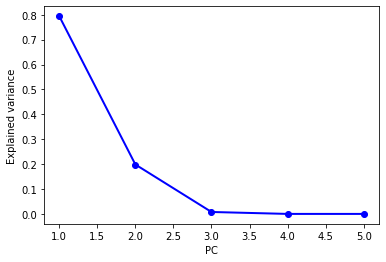

In [38]:
PC_values = np.arange(p) + 1
plt.plot(PC_values, explained_vars, 'o-', linewidth=2, color='blue')
plt.xlabel('PC')
plt.ylabel('Explained variance')
plt.show()

I haven't seen this done in the literature, but a pie chart can also give a sense of how the total variance is shared by the principal components:

['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5']


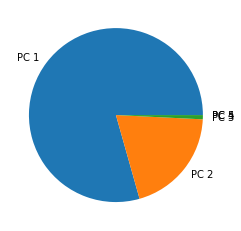

In [39]:
labels=[f'PC {i}' for i in range(1, p+1)]
print(labels)
plt.pie(explained_vars,labels=labels);

Let Y denote the matrix X multipied on the right by U, that is, the data in the new coordinate system adapted to the covariance of the data:

In [40]:
Y=np.matmul(X,U)
print(Y)

[[-1.254  5.312 -0.161  0.052 -0.   ]
 [ 7.126  5.452  0.104  0.057 -0.   ]
 [ 4.825 -1.523 -1.36   0.05   0.   ]
 ...
 [ 0.491  1.313 -0.017 -0.049 -0.   ]
 [-2.241  2.654 -0.493 -0.051  0.   ]
 [ 7.942  2.074  0.083 -0.044  0.001]]


The columns of Y are uncorrelated:

In [41]:
1/(n-1)*np.matmul(np.transpose(Y),Y)

array([[100.59 ,  -0.   ,  -0.   ,  -0.   ,  -0.   ],
       [ -0.   ,  25.137,  -0.   ,   0.   ,   0.   ],
       [ -0.   ,  -0.   ,   0.986,   0.   ,  -0.   ],
       [ -0.   ,   0.   ,   0.   ,   0.002,  -0.   ],
       [ -0.   ,   0.   ,  -0.   ,  -0.   ,   0.   ]])

The columns of the eigenvector matrix $U$ give the weights that are used to calculate the newly found uncorrelated features. More precisely, $u_{ij}$ gives the coefficient (contribution) of the $i$th original feature to the $j$th principal component.

In [42]:
print(U)

[[ 0.559  0.437  0.184  0.539 -0.416]
 [ 0.521  0.103 -0.015 -0.81  -0.248]
 [ 0.011  0.039 -0.965  0.102 -0.238]
 [-0.028 -0.743  0.139  0.084 -0.648]
 [ 0.645 -0.494 -0.125  0.189  0.537]]


We explore now the *correlation* between the $i$th original feature the $j$th principal component. To this end, let $\vec{e}_i$ denote the unit column vector of dimension $p$ whose only nonzero element is a $1$ in the $i$th row.

Then the $i$th original feature is the vector $X \vec{e}_i$, and the $j$th principal component data is $X\vec{u}_j$. The (sample) covariance between these two is given by
$$
\frac{1}{n-1}\vec{e}_i^{T}X^{T}X\vec{u}_j = \vec{e}_i^{T}S\vec{u}_j=\lambda_j\vec{e}_i^{T}\vec{u}_j = \lambda_j u_{ij}
$$
The (sample) variances of the $i$th original feature and the $j$th principal component are
$$
\frac{1}{n-1}\vec{e}_i^{T}X^{T}X\vec{e}_i = \vec{e}_i^{T}S\vec{e}_i= S_{ii}
$$
and
$$
\frac{1}{n-1}\vec{u}_j^{T}X^{T}X\vec{u}_j = \vec{u}_j^{T}S\vec{u}_j =\lambda_j\vec{u}_j^{T}\vec{u}_j = \lambda_j.
$$
Therefore
$$
r_{X_i, Y_j} =\frac{\sqrt{\lambda_j}u_{ij}}{\sqrt{S_{ii}}} .
$$

The magnitude of pure coefficient $u_{ij}$ measures the importance of the contribution of the $i$ original feature to the $j$th principal component in the presence of the other original features. On the other hand, the correlation $r_{X_i, Y_j}$ measures the univariate contribution of the $i$th original feature on the $j$th principal component, disregarding the other original features.

In [43]:
print(S)
np.diag(S)

[[36.24  30.398  0.884 -9.708 30.788]
 [30.398 27.548  0.706 -3.388 32.495]
 [ 0.884  0.706  0.968 -0.884  0.374]
 [-9.708 -3.388 -0.884 13.993  7.41 ]
 [30.788 32.495  0.374  7.41  47.965]]


array([36.24 , 27.548,  0.968, 13.993, 47.965])

In [44]:
invstdevsX = np.zeros((5, 5))
np.fill_diagonal(invstdevsX,np.diag(S)**(-1/2)) 
print(invstdevsX)

[[0.166 0.    0.    0.    0.   ]
 [0.    0.191 0.    0.    0.   ]
 [0.    0.    1.016 0.    0.   ]
 [0.    0.    0.    0.267 0.   ]
 [0.    0.    0.    0.    0.144]]


In [45]:
stdevsY = np.zeros((5, 5))
np.fill_diagonal(stdevsY,eigenvalues**(1/2)) 
print(stdevsY)

[[10.029  0.     0.     0.     0.   ]
 [ 0.     5.014  0.     0.     0.   ]
 [ 0.     0.     0.993  0.     0.   ]
 [ 0.     0.     0.     0.05   0.   ]
 [ 0.     0.     0.     0.     0.   ]]


Here is a the matrix of the correlations between X and Y:

In [46]:
np.matmul(np.matmul(invstdevsX,U),stdevsY)

array([[ 0.931,  0.364,  0.03 ,  0.004, -0.   ],
       [ 0.995,  0.098, -0.003, -0.008, -0.   ],
       [ 0.115,  0.196, -0.974,  0.005, -0.   ],
       [-0.075, -0.997,  0.037,  0.001, -0.   ],
       [ 0.934, -0.358, -0.018,  0.001,  0.   ]])

For the sake of comparison, here is U:

In [47]:
print(U)

[[ 0.559  0.437  0.184  0.539 -0.416]
 [ 0.521  0.103 -0.015 -0.81  -0.248]
 [ 0.011  0.039 -0.965  0.102 -0.238]
 [-0.028 -0.743  0.139  0.084 -0.648]
 [ 0.645 -0.494 -0.125  0.189  0.537]]


The practically $0$ last eigenvalue of $S$ and last almost zero column in the matrix of correlations between $X$ and $Y$ suggests that the last principal component is essentially $0$. This means that we found a linear relation (collinearity) between the original features. The last column of U gives the coefficient of the linear combination of the features that is essentially zero. Since none of these entries in the last column of $U$ are zero, this means that we can write either one of the original features as a linear combination of the other four original features.

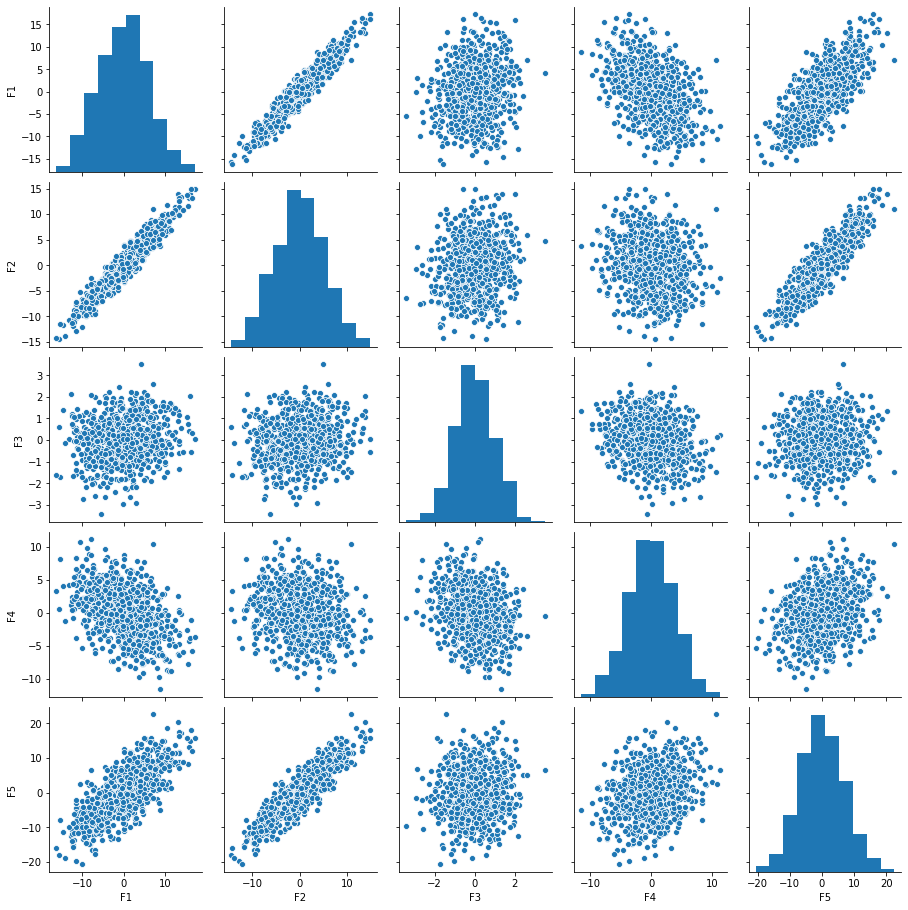

In [48]:
seaborn.pairplot(Our_Data_centered);

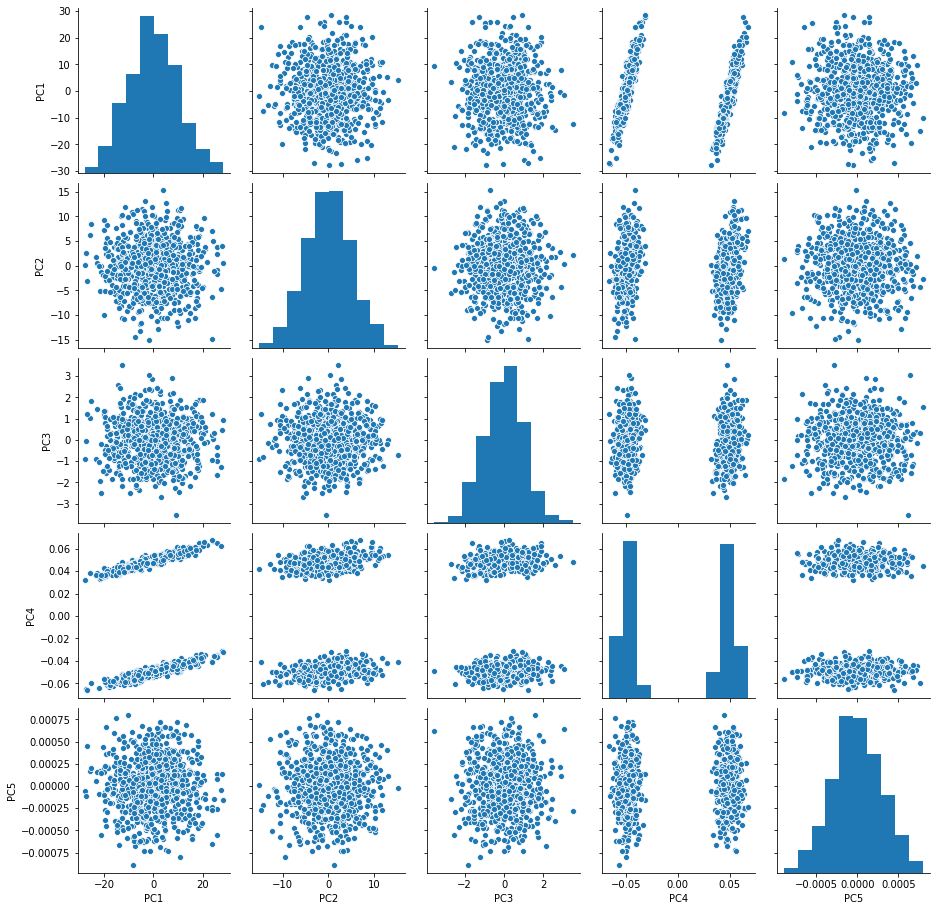

In [49]:
Principals=pandas.DataFrame(data=Y,columns=["PC1","PC2","PC3","PC4","PC5"])
seaborn.pairplot(Principals);

The fourth eigenvalue is also very close to $0$. The pairwise scatterplots reveal that PC4 is on a much smaller scale than the first three principal components, but there is a marked separation between two groups on PC4 - this was intentionally planted into the synthetic data set. Note that no hint of this separation on a small scale was seen on the pairwise scatterplots of the original features above.

Here is the implementation of this in scikit-learn:

In [50]:
X_original=Our_Data.to_numpy() #raw data converted to a numpy array

pca.fit(X_original) #performing PCA on X_original

print("Explained variances:\n",pca.explained_variance_)
print("Explained variance ratios:\n",pca.explained_variance_ratio_)
print("Principal components:\n",pca.components_)

Explained variances:
 [100.59   25.137   0.986   0.002   0.   ]
Explained variance ratios:
 [0.794 0.198 0.008 0.    0.   ]
Principal components:
 [[ 0.559  0.521  0.011 -0.028  0.645]
 [ 0.437  0.103  0.039 -0.743 -0.494]
 [-0.184  0.015  0.965 -0.139  0.125]
 [ 0.539 -0.81   0.102  0.084  0.189]
 [ 0.416  0.248  0.238  0.648 -0.537]]


Note that the principal component matrix above is the transpose of what we called $U$.

Also, note that the signs of some rows here (columns in $U$) are reversed. This is not a bug, it is a naturally occurring phenomenon: there are two unit vectors associated with each principal direction (they are negatives of each other), and this abmiguity cannot be removed.

## Standardizing the original data: PCA based on the correlation (and not the covariance) matrix

If the original features are not in the same physical units or there are major differences between the variances of the features, it may make sense to standardize each feature individually, so that its variance is normalized to $1$. This renders the features essentially unitless, and each of them will have equal importance in the forthcoming variance analysis (which may or may to be desirable, depending on what we are trying to find).

The correlation matrix can be calculated like this:

In [51]:
R=np.matmul(invstdevsX,np.matmul(S,invstdevsX))
print(R)

[[ 1.     0.962  0.149 -0.431  0.738]
 [ 0.962  1.     0.137 -0.173  0.894]
 [ 0.149  0.137  1.    -0.24   0.055]
 [-0.431 -0.173 -0.24   1.     0.286]
 [ 0.738  0.894  0.055  0.286  1.   ]]


In [52]:
Our_Data.corr() #check by built-in Pandas routine

,F1,F2,F3,F4,F5
F1,1.000000,0.962068,0.149196,-0.431110,0.738459
F2,0.962068,1.000000,0.136623,-0.172538,0.893943
F3,0.149196,0.136623,1.000000,-0.240050,0.054812
F4,-0.431110,-0.172538,-0.240050,1.000000,0.286021
F5,0.738459,0.893943,0.054812,0.286021,1.000000


Here we have $1$'s on the main diagonal as expected. This means that all the subsequent calculations will be done with respect to this square matrix. This will lead to different eigenvalues and eigenvectors in general, with different properties.

We can use the sklearn.preprocessing.StandardScaler to achieve the same standardization:

In [53]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_original)
X_scaled=scaler.transform(X_original)
print(X_scaled)

[[ 0.269 -0.028  0.357 -1.052 -0.492]
 [ 1.066  0.805  0.199 -1.132  0.274]
 [ 0.301  0.445  1.335  0.217  0.584]
 ...
 [ 0.136  0.082  0.068 -0.267 -0.049]
 [-0.035 -0.161  0.556 -0.531 -0.391]
 [ 0.887  0.836  0.087 -0.47   0.589]]


To verify, we can do this by hand:

In [54]:
print(np.matmul(X,invstdevsX)) # note that X is centered already

[[ 0.269 -0.028  0.357 -1.051 -0.492]
 [ 1.065  0.805  0.199 -1.132  0.274]
 [ 0.3    0.445  1.334  0.217  0.584]
 ...
 [ 0.136  0.082  0.068 -0.266 -0.049]
 [-0.035 -0.161  0.556 -0.53  -0.391]
 [ 0.886  0.835  0.087 -0.47   0.589]]


Now we compare the findings of the PCA routine for the standardized sample:

Explained variances:
 [2.788 1.365 0.853 0.    0.   ]
Explained variance ratios:
 [0.557 0.273 0.17  0.    0.   ]
Principal components:
 [[-0.581 -0.597 -0.128  0.132 -0.522]
 [-0.14   0.061 -0.481  0.767  0.397]
 [ 0.202  0.049 -0.866 -0.42  -0.175]
 [ 0.613 -0.759  0.021  0.081  0.201]
 [ 0.476  0.247  0.044  0.46  -0.706]]


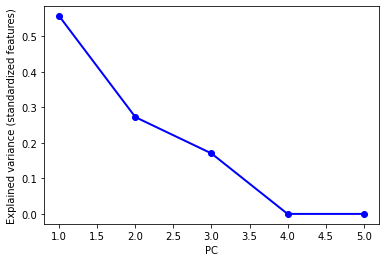

In [55]:
pca2 = PCA() #PCA on standardized variables
pca2.fit(X_scaled)

print("Explained variances:\n",pca2.explained_variance_)
print("Explained variance ratios:\n",pca2.explained_variance_ratio_)
print("Principal components:\n",pca2.components_)

PC_values = np.arange(p) + 1
plt.plot(PC_values, pca2.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('PC')
plt.ylabel('Explained variance (standardized features)')
plt.show()